In [12]:
from functions_text_model import *
import os
import json

In [13]:
current_directory = os.getcwd()
print("Current directory:", current_directory)

contents = os.listdir(current_directory)
print("Contents of current directory:", contents)

#### Change the Dataset here when neccessary!
json_file_path = os.path.join(current_directory, 'data', 'F_data.json')
print(json_file_path)

# Create the DataLoader
# Load the data from the JSON file
with open('data/F_train_set_alternative.json') as file:
    M_train = json.load(file)

with open('data/F_val_set_alternative.json') as file:
    M_val = json.load(file)

# Convert the data to a list of dictionaries
M_train_data = list(M_train.values())
M_val_data = list(M_val.values())

Current directory: /Users/regulafrey/Desktop/Deep_Learning/Deep_Learning_Project/Inclusiveness-in-Sarcasm-Detection
Contents of current directory: ['text-data-preparation.ipynb', 'text-model-training.ipynb', 'hyperparameter-tuning-audio.ipynb', '.DS_Store', 'requirements.txt', 'functions_audio_model_tiny.py', 'functions_text_model.py', 'functions_audio_model.py', 'audio-model-training.ipynb', 'video-model-training.ipynb', '__pycache__', 'perfomance-comparison-with-gpt', 'README.md', 'results', '.gitignore', 'hyperparameter-tuning-text.ipynb', 'audio_model-spectrogram', 'hyperparameter_tuning', 'hubert_base_online_tokenizer.ipynb', 'text-model-evaluation.ipynb', '.git', 'data', 'functions_video_model.py', 'audio-data-preparation.ipynb', 'dataclean.ipynb', 'augmented_labels.txt']
/Users/regulafrey/Desktop/Deep_Learning/Deep_Learning_Project/Inclusiveness-in-Sarcasm-Detection/data/F_data.json


In [14]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import random_split
from sklearn.model_selection import ParameterGrid


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        context = item['context']
        utterance_and_context = ' '.join([sentence for sentence in context] + [utterance]) # Combining the utterance and its context into one string.
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance_and_context)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


train Loss: 0.0320,  ACC: 1.0000, F1-weighted: 1.0000


100%|██████████| 2/2 [00:00<00:00, 43.14it/s]


eval Loss: 1.2396,  ACC: 0.6458, F1-weighted: 0.5125


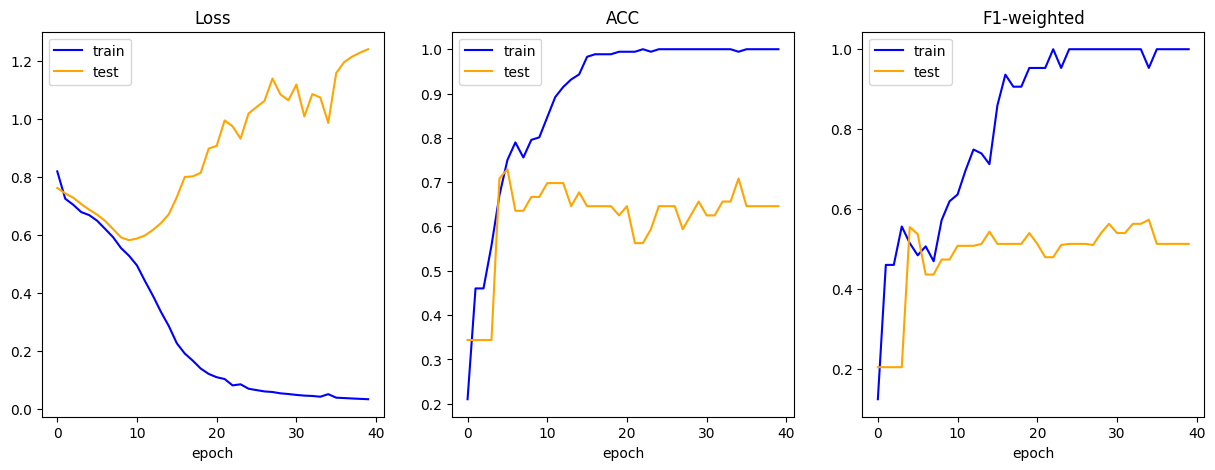

[{'lr': 0.0001, 'batch_size': 16, 'num_epochs': 40, 'weight_decay': 0.05, 'dropout_prob': 0, 'eval_loss': 1.2396124005317688, 'eval_metrics': {'ACC': 0.6458333333333333, 'F1-weighted': 0.5125}}]


In [16]:
torch.manual_seed(42)
    
# Set device
device = torch.device("cpu")

dropout_prob = 0

# Define the hyperparameters to tune
param_grid = {
    'lr': [0.0001],
    'num_epochs': [40],
    'batch_size': [16],
    'weight_decay': [0.05],
    'dropout_prob': [0]
}

# Create a parameter grid
grid = ParameterGrid(param_grid)

# Initialize a list to store the results
results = []

# Define the datasets
train_dataset = SarcasmDataset(M_train_data)
val_dataset = SarcasmDataset(M_val_data)

# For each combination of hyperparameters
for params in grid:

    # Create the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'])

    # Create a new model
    model = BertForSequenceClassification.from_pretrained(
        "prajjwal1/bert-tiny",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
    )

    model.classifier = nn.Sequential(
        nn.Dropout(params['dropout_prob']),
        nn.Linear(in_features=128, out_features=64, bias=True),
        nn.Tanh(),
        nn.Linear(in_features=64, out_features=16, bias=True),
        nn.Tanh(),
        nn.Linear(in_features=16, out_features=2, bias=True)
    )

    model.to(device)

    # Create a new optimizer with the current learning rate
    optimizer = AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    # Create the optimizer  
    criterion = nn.CrossEntropyLoss()

    # Define metrics
    metrics = {'ACC': acc, 'F1-weighted': f1}

    # Initialize lists to store losses and metrics
    train_loss_log, test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for _ in range(len(metrics))]
    test_metrics_log = [[] for _ in range(len(metrics))]

    # Train and evaluate the model for the current number of epochs
    for epoch in range(params['num_epochs']):
        print(f"Epoch {epoch + 1}")
        print('learning rate:', params['lr'], 'batch size:', params['batch_size'], 'num_epochs:', params['num_epochs'])
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_dataloader, device)
        val_loss, val_metrics = evaluate(model, criterion, metrics, val_dataloader, device)

        # Log the losses and metrics
        train_loss_log.append(train_loss)
        test_loss_log.append(val_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, val_metrics)

    # Store the results
    results.append({
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'num_epochs': params['num_epochs'],
        'weight_decay': params['weight_decay'],
        'dropout_prob': params['dropout_prob'],
        'eval_loss': val_loss,
        'eval_metrics': val_metrics
    })

    # Plot and save the training and testing metrics
    plot_filename = f'results/plot_lr_{params["lr"]}_bs_{params["batch_size"]}_wd_{params["weight_decay"]}_dp_{params["dropout_prob"]}.png'
    plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

# Save the results to a JSON file
#results_path = 'results/text_hyperparameter_mixed_alternative.json'
#os.makedirs(os.path.dirname(results_path), exist_ok=True)

#with open(results_path, 'w') as f:
    #json.dump(results, f, indent=4)

print(results)